# Transfer learning with MobileNetv2

## Imports

In [1]:
import torch
from torch import nn

from torch.utils.data import DataLoader 

import torchvision

from pathlib import Path

from matplotlib import pyplot as plt

from PIL import Image

import pandas as pd

## Functions

In [2]:
def prepare_and_get_data_path(where_is_running: str = 'colab'):
    match where_is_running:
        case 'colab':
            from google.colab import userdata
            import os

            kaggle_target_path = Path('/root/.kaggle/kaggle.json')

            kaggle_target_path.parent.mkdir(exist_ok=True, parents=True)

            with open(kaggle_target_path, 'w') as f:
                f.write(userdata.get('Kaggle'))

            os.system('kaggle datasets download -d fruits-100')
            os.system('unzip -q fruits-100.zip -d fruits-100')
            os.system('rm -r fruits-100.zip')

            data_path = Path('fruits-100')

        case 'pc':
            data_path = Path(
                '/home/ramin/ramin_programs/files/datasets/fruits-100')

        case 'kaggle':
            data_path = Path('fruits-100')

    return data_path


def find_device():
    device = 'cpu'

    if torch.cuda.is_available():
        device = 'cuda'
    elif torch.backends.mps.is_available():
        device = 'mps'

    return device


def load_data(data_path: Path) -> list[DataLoader]:
    tr = torchvision.transforms.Compose(
        [torchvision.transforms.Resize(
            [90, 160]), torchvision.transforms.ToTensor(), ]
    )

    train_data_path = data_path / 'train'
    valid_data_path = data_path / 'val'

    tr = torchvision.transforms.Compose(
        [torchvision.transforms.Resize(
            [90, 160]), torchvision.transforms.ToTensor(),]
    )

    train_image_folder = torchvision.datasets.ImageFolder(
        train_data_path, transform=tr)
    valid_image_folder = torchvision.datasets.ImageFolder(
        valid_data_path, transform=tr)

    train_data_loader = DataLoader(
        train_image_folder, batch_size=32, shuffle=True)
    val_data_loader = DataLoader(
        valid_image_folder, batch_size=32, shuffle=True)

    return train_data_loader, val_data_loader


def load_model(device: str = 'cuda') -> nn.Module:
    model = torchvision.models.mobilenet_v2(
        weights=torchvision.models.MobileNet_V2_Weights.IMAGENET1K_V1)
    for param in model.parameters():
        param.requires_grad = False

    model.classifier[1] = nn.Linear(1280, 100)
    model = model.to(device)

    return model


def train(model: nn.Module, data_loader: DataLoader, loss_fn: nn.Module, optimizer: torch.optim.Optimizer,
          device: str = 'cuda', tensorboard_writer=None, epoch: int = 0):
    model = model.to(device)
    model.train()

    running_loss = 0
    i_c = 0
    number_of_batches = len(data_loader)

    for i, (images, labels) in enumerate(data_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        prediction = model(images)
        loss = loss_fn(prediction, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        i_c += 1
        if (i % 10 == 9) or i == number_of_batches - 1:
            print(
                f'\r{i + 1}/{number_of_batches}, loss = {loss.item():>4f}', end='')
            if tensorboard_writer:
                tensorboard_writer.add_scalar(
                    'training loss', running_loss / i_c, epoch * number_of_batches + i)
            running_loss = 0
            i_c = 0
    print()


def evaluate(model: nn.Module,
             data_loader: torch.utils.data.DataLoader,
             loss_fn: nn.Module,
             device: str = 'cuda') -> tuple[torch.float, torch.float]:

    model = model.to(device)
    model.eval()

    data_size = len(data_loader.dataset)
    number_of_batches = len(data_loader)

    loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            prediction = model(images)
            loss += loss_fn(prediction, labels).item()
            correct += (prediction.argmax(1) ==
                        labels).type(torch.float).sum().item()

        loss /= number_of_batches
        correct /= data_size

    return correct, loss


def predict(model: nn.Module,
            test_data_path: Path,
            device: str = 'cuda') -> pd.DataFrame:
    model = model.to(device)
    model.eval()

    tr = torchvision.transforms.Compose(
        [torchvision.transforms.Resize([90, 160]), torchvision.transforms.ToTensor(), ]
    )

    image_paths = test_data_path.rglob('*.jpg')

    result = {'image_path': [], 'prediction': []}

    with torch.no_grad():
        for image_path in image_paths:
            image = Image.open(image_path)

            image_tensor = tr(image).to(device)
            image_tensor = image_tensor.unsqueeze(0)

            with torch.no_grad():
                prediction = model(image_tensor)
            prediction = torch.argmax(prediction)

            result['image_path'].append(image_path)
            result['prediction'].append(prediction.detach().cpu().numpy())

    return pd.DataFrame(result)


## Device

In [3]:
device = find_device()

print(f'device: {device}')

device: cuda


## Data

In [4]:
data_path = prepare_and_get_data_path('pc')

In [5]:
train_data_loader, val_data_loader = load_data(data_path)

tensor(62)


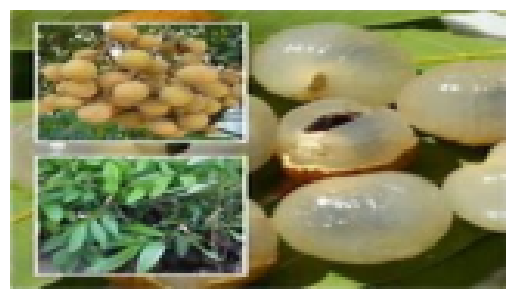

In [6]:
for tensor_image, label in train_data_loader:
    figure, axes = plt.subplots(1,1)

    axes.imshow(torchvision.transforms.ToPILImage()(tensor_image[0]))
    axes.set_axis_off()
    print(label[0])
    break

## Model

In [7]:
model = load_model(device)
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [8]:
print(model)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

## Train

In [9]:
for epoch in range(5):
      print(f'in epoch: {epoch}')
      train(model, train_data_loader, loss_fn, optimizer, device)
      accuracy, loss = evaluate(model, val_data_loader, loss_fn, device)
      print(f'validation -> accuracy: {accuracy:.2f}, loss: {loss:.2f}')

in epoch: 0
1250/1250, loss = 1.758369
validation -> accuracy: 0.51, loss: 1.90
in epoch: 1
1250/1250, loss = 2.461351
validation -> accuracy: 0.53, loss: 1.82
in epoch: 2
1250/1250, loss = 2.260238
validation -> accuracy: 0.55, loss: 1.77
in epoch: 3
1250/1250, loss = 1.929075
validation -> accuracy: 0.55, loss: 1.80
in epoch: 4
1250/1250, loss = 1.947122
validation -> accuracy: 0.55, loss: 1.77


## Test

In [10]:
result = predict(model, data_path/'test', device=device)

In [11]:
result

,image_path,prediction
0,/home/ramin/ramin_programs/files/datasets/frui...,49
1,/home/ramin/ramin_programs/files/datasets/frui...,94
2,/home/ramin/ramin_programs/files/datasets/frui...,49
3,/home/ramin/ramin_programs/files/datasets/frui...,49
4,/home/ramin/ramin_programs/files/datasets/frui...,49
...,...,...
4995,/home/ramin/ramin_programs/files/datasets/frui...,31
4996,/home/ramin/ramin_programs/files/datasets/frui...,31
4997,/home/ramin/ramin_programs/files/datasets/frui...,31
4998,/home/ramin/ramin_programs/files/datasets/frui...,31
